In [3]:
import numpy as np
import pandas as pd
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.base import TransformerMixin
from sklearn.decomposition import FastICA#, TruncatedSVD, PCA, NMF
from sklearn.preprocessing import StandardScaler
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from lime import submodular_pick

In [4]:
tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')

# to convert contractions picked up by word_tokenize() into full words
contractions = {
    "n't": 'not',
    "'ve": 'have',
    "'s": 'is',  # note that this will include possessive nouns
    'gonna': 'going to',
    'gotta': 'got to',
    "'d": 'would',
    "'ll": 'will',
    "'re": 'are',
    "'m": 'am',
    'wanna': 'want to'
}


# to convert nltk_pos tags to wordnet-compatible PoS tags
def convert_pos_wordnet(tag):
    tag_abbr = tag[0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }

    if tag_abbr in tag_dict:
        return tag_dict[tag_abbr]


class Text2Embed(TransformerMixin):
    """ Description:
        Transformer that takes in a list of strings, calculates the word-context matrix
        (with any specified transformations), reduces the dimensionality of these word
        embeddings, and then provides the text embeddings of a (new) list of texts
        depending on which words in the "vocab" occur in the (new) strings.
    """

    # initialize class & private variables
    def __init__(self,
                 window_size=4,
                 remove_stopwords=True,
                 add_start_end_tokens=True,
                 lowercase=False,
                 lemmatize=False,
                 pmi=False,
                 spmi_k=1,
                 laplace_smoothing=0,
                 pmi_positive=False,
                 sppmi_k=1,
                 n_components=250,
                 random_state=4):

        """ Params:
                window_size: size of +/- context window (default = 4)
                remove_stopwords: boolean, whether or not to remove NLTK English stopwords
                add_start_end_tokens: boolean, whether or not to append <START> and <END> to the
                beginning/end of each document in the corpus (default = True)
                lowercase: boolean, whether or not to convert words to all lowercase
                lemmatize: boolean, whether or not to lemmatize input text
                pmi: boolean, whether or not to compute pointwise mutual information
                spmi_k: numeric, shifted pmi value
                pmi_positive: boolean, whether or not to compute positive PMI
                sppmi_k: numeric, shifted ppmi value
                n_components: number of components for PCA/FastICA
                random_state: set seed for FastICA
        """
        self.window_size = window_size
        self.remove_stopwords = remove_stopwords
        self.add_start_end_tokens = add_start_end_tokens
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.pmi = pmi
        self.spmi_k = spmi_k
        self.laplace_smoothing = laplace_smoothing
        self.pmi_positive = pmi_positive
        self.sppmi_k = sppmi_k
        self.corpus = None
        self.clean_corpus = None
        self.vocabulary = None
        self.X = None
        self.doc_terms_lists = None
        self.ica = FastICA(n_components=n_components, random_state=random_state)
        self.scaler = StandardScaler()
        self.word_embeddings = None
        self.text_embeddings = None

    def fit(self, corpus, y=None):

        """ Learn the dictionary of all unique tokens for given corpus. Compute the co-occurrence matrix
            for input corpus and window_size, using term dictionary. Reduce dimensionality of embeddings.

            Params:
                corpus: list of strings

            Returns: self
        """
        self.corpus = corpus

        term_dict = dict()
        k = 0
        corpus_words = []
        clean_corpus = []
        doc_terms_lists = []
        detokenizer = TreebankWordDetokenizer()
        lemmatizer = WordNetLemmatizer()

        for text in corpus:
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)

            words = word_tokenize(text)

            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words

            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())

                words = clean_words

            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]

                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)

                words = clean_words

            # detokenize trick taken from this StackOverflow post:
            # https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
            # and NLTK treebank documentation:
            # https://www.nltk.org/_modules/nltk/tokenize/treebank.html
            text = detokenizer.detokenize(words)
            clean_corpus.append(text)

            [corpus_words.append(word) for word in words]

            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']

            doc_terms_lists.append(words)

        self.clean_corpus = clean_corpus

        self.doc_terms_lists = doc_terms_lists

        corpus_words = list(set(corpus_words))

        if self.add_start_end_tokens:
            corpus_words = ['<START>'] + corpus_words + ['<END>']

        corpus_words = sorted(corpus_words)

        for el in corpus_words:
            term_dict[el] = k
            k += 1

        self.vocabulary = term_dict

        num_terms = len(self.vocabulary)
        window = self.window_size
        X = np.full((num_terms, num_terms), self.laplace_smoothing)

        for el in range(len(clean_corpus)):
            words = doc_terms_lists[el]

            # Construct word-context matrix
            for i in range(len(words)):
                target = words[i]

                # grab index from dictionary
                target_dict_index = self.vocabulary[target]

                # find left-most and right-most window indices for each target word
                left_end_index = max(i - window, 0)
                right_end_index = min(i + window, len(words) - 1)

                # loop over all words within window
                # NOTE: this will include the target word; make sure to skip over it
                for j in range(left_end_index, right_end_index + 1):

                    # skip "context word" where the "context word" index is equal to the
                    # target word index
                    if j != i:
                        context_word = words[j]

                        # count co-occurrence of target and context words
                        X[target_dict_index, self.vocabulary[context_word]] += 1

        # if pmi = True, compute pmi matrix from word-context raw frequencies
        # more concise code taken from this StackOverflow post:
        # https://stackoverflow.com/questions/58701337/how-to-construct-ppmi-matrix-from-a-text-corpus
        if self.pmi:
            denom = X.sum()
            col_sums = X.sum(axis=0)
            row_sums = X.sum(axis=1)

            expected = np.outer(row_sums, col_sums) / denom

            X = X / expected

            for i in range(X.shape[0]):
                for j in range(X.shape[1]):

                    if X[i, j] > 0:
                        X[i, j] = np.log(X[i, j]) - np.log(self.spmi_k)

                        if self.pmi_positive:
                            X[i, j] = max(X[i, j] - np.log(self.sppmi_k), 0)

        # note that X is a dense matrix
        self.X = X

        word_embeddings = self.scaler.fit_transform(self.X)
        word_embeddings = self.ica.fit_transform(word_embeddings)

        # transformed WordICA embeddings
        self.word_embeddings = word_embeddings

        return self

    def transform(self, new_corpus=None, y=None):

        """ Get text embeddings for given corpus, using term dictionary and word embeddings obtained
            with fit method.

            Returns: text embeddings (shape: num texts by embedding dimensions)
        """
        lemmatizer = WordNetLemmatizer()
        #if type(new_corpus) != list:
            #exit()

        for k in range(len(new_corpus)):
            text = new_corpus[k]
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
            text_vec = np.zeros(self.word_embeddings.shape[1])
            words = word_tokenize(text)
            tracker = 0  # to track whether we've encountered a word for which we have an embedding (in each tweet)

            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words

            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())

                words = clean_words

            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]

                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)

                words = clean_words

            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']

            for i in range(len(words)):
                word = words[i]
                if word in self.vocabulary:
                    word_embed_vec = self.word_embeddings[self.vocabulary[word], :]
                    if tracker == 0:
                        text_matrix = word_embed_vec
                    else:
                        text_matrix = np.vstack((text_matrix, word_embed_vec))

                    # only increment if we have come across a word in the embeddings dictionary
                    tracker += 1

            for j in range(len(text_vec)):
                text_vec[j] = text_matrix[:, j].mean()

            if k == 0:
                full_matrix = text_vec
            else:
                full_matrix = np.vstack((full_matrix, text_vec))

        self.text_embeddings = full_matrix

        return self.text_embeddings.copy()

In [5]:
# instantiate embedder
embedder = Text2Embed(window_size = 15, lowercase = True, lemmatize = True, pmi = True)
embedder.fit(tweets['Tweet'])

In [7]:
embedded_tweets = embedder.transform(tweets['Tweet'])

In [8]:
# instantiate classification algorithm

# round 1 winner
svc = SVC(C = 1, kernel = 'rbf', probability = True)

class1_train_indices = list(range(100))
class0_train_indices = list(range(280,380))

train_X = embedded_tweets[[class1_train_indices + class0_train_indices],:][0]

hundred_ones = [1]*100
hundred_zeros = [0]*100
train_Y = hundred_ones + hundred_zeros

# fit SVC model on training subset of tweet embeddings
svc.fit(train_X, train_Y)

SVC(C=1, probability=True)

In [37]:
class1_test_indices = list(range(100,280))
class0_test_indices = list(range(380,560))
test_X = tweets['Tweet'][class1_test_indices + class0_test_indices]
test_X = test_X.reset_index(drop = True)

In [28]:
c = make_pipeline(embedder, svc)

explainer = LimeTextExplainer(class_names = ['Reliable', 'Unreliable'])

# Which tweet(s) to look at:
idx = 527
exp = explainer.explain_instance(tweets['Tweet'][idx], c.predict_proba, num_features = 6)

In [29]:
from lime import submodular_pick

In [38]:
sp_obj = submodular_pick.SubmodularPick(explainer,
                                        test_X,
                                        c.predict_proba,
                                        sample_size = 50,
                                        num_features = 6,
                                        num_exps_desired = 5)

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

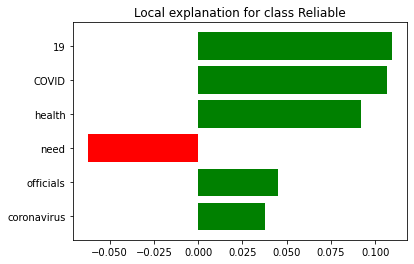

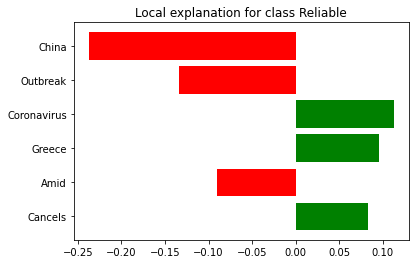

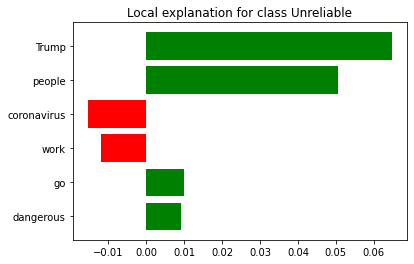

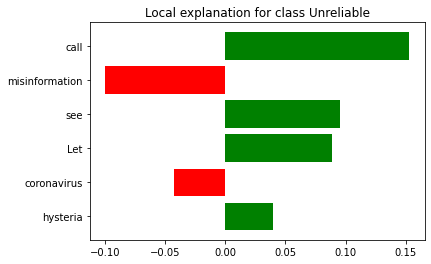

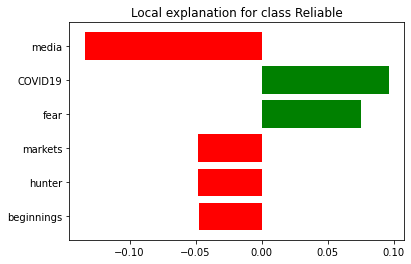

In [39]:
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations]